In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 63.0 MB/s eta 0:00:00


In [23]:
import os
import numpy as np
import pandas as pd
from pyvi import ViTokenizer
from scipy.spatial.distance import cosine, euclidean
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Tiền xử lý dữ liệu

In [4]:
pathdata = '/content/drive/MyDrive/Data full/merged_data (2).txt'
stopwords_path = '/content/drive/MyDrive/Data full/stopwords.csv'
model_path = '/content/drive/MyDrive/Data full/GloVe_model.model'

In [5]:
# Đọc dữ liệu từ file
train_data = pd.read_csv(pathdata, delimiter='\t', header=None, names=['text'])
train_data['text_tokenized'] = train_data['text'].apply(ViTokenizer.tokenize)

In [6]:
# Đọc danh sách stopwords
stopwords_data = pd.read_csv(stopwords_path, sep="\t", encoding='utf-8')
stopwords_set = set(stopwords_data['stopwords'])

In [7]:
# Tiền xử lý dữ liệu
train_data['text_cleaned'] = train_data['text_tokenized'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_set]))

In [8]:
# Chuyển dữ liệu huấn luyện thành danh sách các từ
sentences = [text.split() for text in train_data['text_cleaned']]

### Xây dựng mô hình

In [9]:
# Tạo từ điển (vocabulary)
vocabulary = set([word for sentence in sentences for word in sentence])
vocabulary_size = len(vocabulary)
word_to_index = {word: index for index, word in enumerate(vocabulary)}

In [10]:
# Xây dựng ma trận đồng xuất hiện
cooccurrence_matrix = np.zeros((vocabulary_size, vocabulary_size))
window_size = 5

for sentence in sentences:
    for i in range(len(sentence)):
        center_word = sentence[i]
        center_word_index = word_to_index[center_word]

        left_context = sentence[max(0, i - window_size):i]
        right_context = sentence[i + 1:i + window_size + 1]

        for context_word in left_context + right_context:
            context_word_index = word_to_index[context_word]
            cooccurrence_matrix[center_word_index][context_word_index] += 1

In [11]:
# Tính toán ma trận trọng số
weighting_factor = 0.75

In [12]:
# Khởi tạo ma trận embedding và vector bias
embedding_dim = 100
word_embedding_matrix = np.random.randn(vocabulary_size, embedding_dim) * 0.01
context_embedding_matrix = np.random.randn(vocabulary_size, embedding_dim) * 0.01
bias_vector = np.random.randn(vocabulary_size) * 0.01

In [13]:
# Huấn luyện mô hình GloVe
learning_rate = 0.01
epochs = 100

for epoch in range(epochs):
    for sentence in sentences:
        for i in range(len(sentence)):
            center_word = sentence[i]
            center_word_index = word_to_index[center_word]

            left_context = sentence[max(0, i - window_size):i]
            right_context = sentence[i + 1:i + window_size + 1]

            for context_word in left_context + right_context:
                context_word_index = word_to_index[context_word]
                cooccurrence = cooccurrence_matrix[center_word_index][context_word_index]

                if cooccurrence > 0:
                    weight = np.log(cooccurrence)
                    error = (
                        np.dot(word_embedding_matrix[center_word_index], context_embedding_matrix[context_word_index]) +
                        bias_vector[center_word_index] +
                        bias_vector[context_word_index] -
                        weight
                    )

                    word_embedding_matrix[center_word_index] -= learning_rate * error * context_embedding_matrix[context_word_index]
                    context_embedding_matrix[context_word_index] -= learning_rate * error * word_embedding_matrix[center_word_index]
                    bias_vector[center_word_index] -= learning_rate * error
                    bias_vector[context_word_index] -= learning_rate * error

In [14]:
# Lưu mô hình
np.savez_compressed(model_path, word_embedding_matrix=word_embedding_matrix, vocabulary=list(vocabulary))

In [16]:
# Load ma trận nhúng từ
model_data = np.load("/content/drive/MyDrive/Data full/GloVe_model.model.npz", allow_pickle=True)
word_embedding_matrix = model_data['word_embedding_matrix']
vocabulary = set(model_data['vocabulary'])

In [17]:
# Tìm từ có độ tương đồng cao nhất với từ "Hồ_Chí_Minh"
word_index = list(vocabulary).index("Hồ_Chí_Minh")
word_vector = word_embedding_matrix[word_index]
similarity_scores = [(word, 1 - cosine(word_vector, word_embedding_matrix[index])) for index, word in enumerate(vocabulary)]
similarity_scores.sort(key=lambda x: x[1], reverse=True)

In [18]:
# In các từ có độ tương đồng cao nhất
top_similar_words = similarity_scores[:10]  # Số lượng từ có độ tương đồng cao nhất để hiển thị
for word, similarity in top_similar_words:
    print(f"{word}: {similarity}")

Hồ_Chí_Minh: 1
chân_dung: 0.5159368563726097
UBND: 0.5157162496790365
hội_đồng: 0.462396913480457
chức_danh: 0.4567450531703958
trúng_cử_chỉ: 0.446808411098893
lẻ_tẻ: 0.44034564201660764
cựu_chiến_binh: 0.43139423504355234
bàn_thờ: 0.42036978793144186
CHXHCN: 0.41614717449563576


In [19]:
# Tính khoảng cách giữa hai từ "máy_tính" và "Độc_lập"
word1 = "máy_tính"
word2 = "Độc_lập"
word1_index = list(vocabulary).index(word1)
word2_index = list(vocabulary).index(word2)
word1_vector = word_embedding_matrix[word1_index]
word2_vector = word_embedding_matrix[word2_index]
euclidean_distance = euclidean(word1_vector, word2_vector)
print(f"Khoảng cách giữa '{word1}' và '{word2}' là: {euclidean_distance}")

Khoảng cách giữa 'máy_tính' và 'Độc_lập' là: 2.276637442386886


In [20]:
# Trích xuất vectơ word embedding của từ "máy_tính"
word = "máy_tính"
word_index = list(vocabulary).index(word)
word_embedding = word_embedding_matrix[word_index]
print(f"Vectơ word embedding của từ '{word}': {word_embedding}")

Vectơ word embedding của từ 'máy_tính': [-0.24776844 -0.02975664  0.10421864  0.13352544 -0.0410504   0.1038184
 -0.01704461 -0.26191039 -0.15154306  0.15532869 -0.01372871 -0.00049787
 -0.04218641 -0.08617482 -0.22091362 -0.01089802 -0.04361735  0.12721319
 -0.08273773 -0.07761826 -0.18024843 -0.28974137 -0.11076883 -0.01072916
 -0.05340018 -0.22657668 -0.11698086  0.13285114  0.27157502  0.13016267
  0.12495206  0.06296253 -0.17956508  0.13374973 -0.03695381  0.23459228
 -0.22519543  0.1641799   0.03312371  0.18426087  0.00640753  0.03051855
 -0.05257363  0.31224528 -0.13926774 -0.09021184 -0.07465046  0.08006857
 -0.06300899 -0.29505799 -0.04704756 -0.16887663 -0.11407068  0.20960008
 -0.07478021 -0.10844136 -0.08172921 -0.03397601  0.09590554 -0.25984766
 -0.28623362  0.18394536  0.13060861 -0.17083371  0.15315226 -0.0455652
 -0.17420279  0.0575114   0.04742545 -0.06384326 -0.02828254 -0.11304162
 -0.01180852 -0.06330581  0.14679096  0.19831738  0.0382295   0.07024751
 -0.2893076  

###Visualize

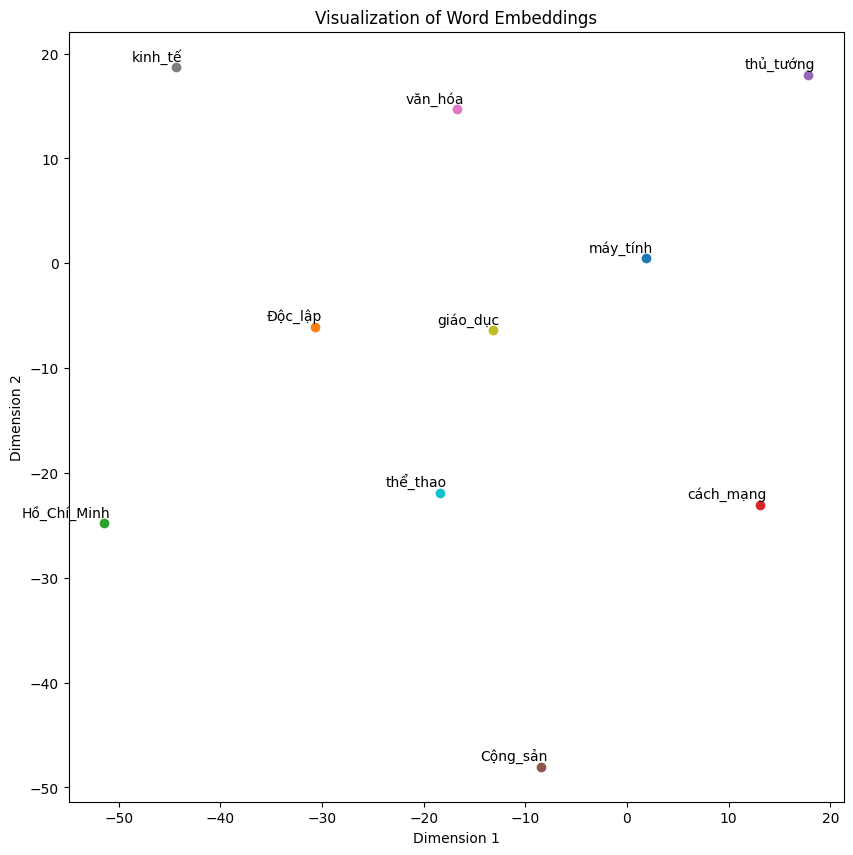

In [21]:
# Các từ cần phân tích
words_to_analyze = ["máy_tính", "Độc_lập", "Hồ_Chí_Minh", "cách_mạng", "thủ_tướng", "Cộng_sản", "văn_hóa", "kinh_tế", "giáo_dục", "thể_thao"]

# Lấy các vector nhúng từ
word_embeddings = []
words = []

for word in words_to_analyze:
    if word in vocabulary:
        word_embeddings.append(word_embedding_matrix[list(vocabulary).index(word)])
        words.append(word)

# Áp dụng t-SNE để giảm chiều
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
word_embeddings_tsne = tsne.fit_transform(np.array(word_embeddings))

# Biểu diễn các từ trên biểu đồ
plt.figure(figsize=(10, 10))
for i in range(len(words)):
    x, y = word_embeddings_tsne[i, :]
    plt.scatter(x, y)
    plt.annotate(words[i], xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Visualization of Word Embeddings')
plt.show()